# IITM - MLP - Week 10 (Dont run: Takes hours)

## Imports

In [28]:
# ---------- Common ------------
import os, time, json, random, ast
from datetime import datetime ; from collections import Counter; from pprint import pprint; from statistics import mode

# ---------- Data Manipulation ------------
import pandas as pd; import numpy as np

# ---------- Data Visualization ------------
from pandas.plotting import scatter_matrix
from pandas.core import missing
import matplotlib as mpl; from matplotlib import pyplot as plt; from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
import plotly.express as px

# ---------- Sklearn ------------
from sklearn import set_config

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, cross_validate, cross_val_predict, validation_curve, learning_curve, ShuffleSplit, GridSearchCV, RandomizedSearchCV, KFold, RepeatedKFold, permutation_test_score
from sklearn.preprocessing import add_dummy_feature, OrdinalEncoder, OneHotEncoder, LabelBinarizer, LabelEncoder, MultiLabelBinarizer, MinMaxScaler, MaxAbsScaler, StandardScaler, FunctionTransformer, PolynomialFeatures, KBinsDiscretizer
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, SGDRegressor, Ridge, RidgeCV, Lasso, LassoCV, Perceptron, SGDClassifier, RidgeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score, max_error, mean_absolute_error, r2_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, accuracy_score, classification_report, hinge_loss, make_scorer, log_loss
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, GenericUnivariateSelect, mutual_info_classif, mutual_info_regression, chi2, f_classif, f_regression, RFE, RFECV, SequentialFeatureSelector, SelectFromModel
from sklearn.datasets import load_iris, fetch_california_housing, make_blobs, make_regression, make_classification, make_multilabel_classification, fetch_openml

from sklearn.tree import export_text, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer

# ---------- Keras dataset --------
# from keras.datasets import mnist # takes time for loading data

# ---------- Imblearn ------------
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# ---------- Scipy ------------
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau, loguniform, uniform

# ---------- Extras ------------
import pickle
# pickle.dump(model, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

import tempfile

import warnings
warnings.filterwarnings("ignore")  # supress all warning (use with care)

In [29]:
from xgboost import XGBClassifier, XGBRegressor 
# extreme gradient boosting : xgboost

## Presets

In [30]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params)

# set_config(display='diagram')

np.random.seed(306)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# mpl.rc("figure", figsize=(8,6))

# Load MNIST data from keras

In [4]:
# from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Flattening 28 * 28 pixels to 784 features.
X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)

X_train = X_train/255
X_test = X_test/255

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 784) (60000,) (10000, 784) (10000,)


# Load California Housing Dataset

In [13]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
labels *= 100

In [14]:
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

# Common Functions

In [11]:
def train_classifiers(estimator, X_train, y_train, cv, name):
    estimator.fit(X_train, y_train)
    cv_train_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='f1_macro')
    print(f"\nOn an average, {name} model has f1 score of {cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on training set\n")

In [10]:
def eval_(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    
    print(f"\n# Classification report:\n{classification_report(y_test, y_pred)}\n")
    
    print(f"\n# Confusion Matrix:\n")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.grid(False)
    plt.title('Çonfusion Matrix')
    plt.show()  

In [15]:
def train_regressor(estimator, X_train, y_train, cv, name):
    cv_results = cross_validate(estimator, 
                                X_train, 
                                y_train, 
                                cv=cv, 
                                scoring='neg_mean_absolute_error', 
                                return_train_score=True, 
                                return_estimator=True)
    
    cv_train_error = -1 * (cv_results['train_score'])
    cv_test_error = -1 * (cv_results['test_score'])
    
    print(f'On an average, {name} makes an error of {cv_train_error.mean():.3f}k +/- {cv_train_error.std():.3f}k on the training set')
    print(f'On an average, {name} makes an error of {cv_test_error.mean():.3f}k +/- {cv_test_error.std():.3f}k on the test set')

# Decision tree, Bagging, Random Forest Classifier : MNIST

Bagging Classifier: uses decision tree as a default classifier and trains multiple decision treee classifier on different bags ontaoned through bootstrap sampling of training set

Random Forest classifier: its also a bagging technique which trains different decision treee classifier by randomly selecting attributes for splitting on bags of bootstrap sample of training set

## Decision Trees


On an average, decision tree model has f1 score of 0.867 +/- 0.003 on training set


# Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       980
           1       0.95      0.96      0.96      1135
           2       0.87      0.86      0.86      1032
           3       0.83      0.84      0.84      1010
           4       0.87      0.88      0.88       982
           5       0.83      0.83      0.83       892
           6       0.89      0.88      0.89       958
           7       0.92      0.90      0.91      1028
           8       0.82      0.80      0.81       974
           9       0.84      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000



# Confusion Matrix:



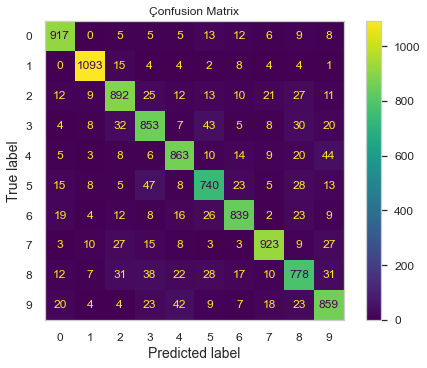

In [12]:
dt_pipeline = Pipeline([('classifier', DecisionTreeClassifier())])

train_classifiers(dt_pipeline, X_train, y_train, cv, "decision tree")
eval_(dt_pipeline, X_test, y_test)

## Bagging


On an average, bagging model has f1 score of 0.936 +/- 0.004 on training set


# Classification report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.92      0.94      0.93      1032
           3       0.92      0.92      0.92      1010
           4       0.94      0.94      0.94       982
           5       0.92      0.92      0.92       892
           6       0.96      0.95      0.95       958
           7       0.96      0.95      0.95      1028
           8       0.92      0.91      0.91       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



# Confusion Matrix:



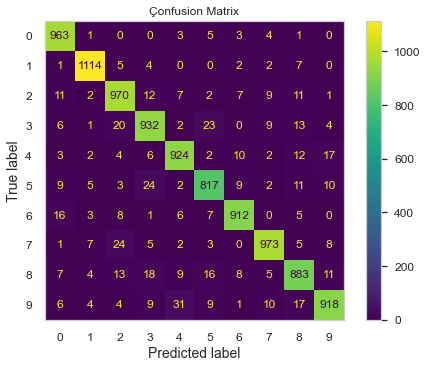

In [20]:
bagging_pipeline = Pipeline([('classifier', BaggingClassifier())])

train_classifiers(bagging_pipeline, X_train, y_train, cv, 'bagging')
eval_(bagging_pipeline, X_test, y_test)

## Random Forest


On an average, random forest model has f1 score of 0.967 +/- 0.002 on training set


# Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Confusion Matrix:



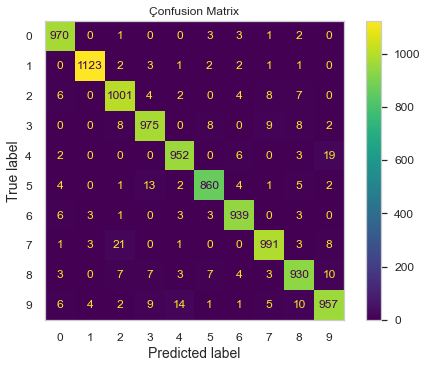

In [21]:
rf_pipeline = Pipeline([('classifier', RandomForestClassifier())])

train_classifiers(rf_pipeline, X_train, y_train, cv, 'random forest')
eval_(rf_pipeline, X_test, y_test)

# random forest gives 97% accuracy and similar accuracy was obtained using K nearest neighbours (Week 7, 8)

# Bagging, Random Forest Regresssor : California Housing

In [16]:
train_regressor(DecisionTreeRegressor(), com_train_features, com_train_labels, cv, 'decision tree regressor') # overfitted

On an average, decision tree regressor makes an error of 0.000k +/- 0.000k on the training set
On an average, decision tree regressor makes an error of 47.404k +/- 1.376k on the test set


In [17]:
train_regressor(BaggingRegressor(), com_train_features, com_train_labels, cv, 'bagging regressor') # bagging helps to reduce varience or overfitting

On an average, bagging regressor makes an error of 14.417k +/- 0.137k on the training set
On an average, bagging regressor makes an error of 35.270k +/- 0.784k on the test set


In [18]:
train_regressor(RandomForestRegressor(), com_train_features, com_train_labels, cv, 'random forest regressor') # RF performs better than bagging

On an average, random forest regressor makes an error of 12.640k +/- 0.070k on the training set
On an average, random forest regressor makes an error of 33.203k +/- 0.720k on the test set


## Hyper-parameter tuning

In [22]:
param_distributions = {'n_estimators': [5,10,50,100,500], 
                       'max_leaf_nodes': [10,50,100]}

search_cv = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_distributions, 
                               scoring='neg_mean_absolute_error', n_iter=10, random_state=0, n_jobs=-1)

search_cv.fit(com_train_features, com_train_labels)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_leaf_nodes': [10, 50, 100],
                                        'n_estimators': [5, 10, 50, 100, 500]},
                   random_state=0, scoring='neg_mean_absolute_error')

In [23]:
columns = [f'param_{name}' for name in param_distributions.keys()]
columns += ['mean_test_error', 'std_test_error']
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results['mean_test_error'] = -cv_results['mean_test_score']
cv_results['std_test_error'] = -cv_results['std_test_score']
cv_results[columns].sort_values(by='mean_test_error')

,param_n_estimators,param_max_leaf_nodes,mean_test_error,std_test_error
4,500,100,40.623029,-0.758790
7,100,100,40.681355,-0.760984
8,5,100,42.117232,-0.824251
3,500,50,43.744893,-0.791890
9,50,50,43.822022,-0.973701
2,100,50,43.844502,-0.883712
1,10,50,44.185876,-1.189415
6,50,10,54.929169,-1.247509
5,500,10,55.015869,-1.066362
0,10,10,55.472634,-0.755866


In [24]:
error = -search_cv.score(test_features, test_labels)
print(f'On average, our random forest regressor makes an error of {error: .2f}k$')

On average, our random forest regressor makes an error of  40.32k$


# AdaBoost, Gradient Boosting, XGBoost Classifier : MNIST

## AdaBoostClassifier


On an average, AdaBoostClassifier model has f1 score of 0.712 +/- 0.016 on training set


# Classification report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       980
           1       0.85      0.94      0.90      1135
           2       0.79      0.58      0.67      1032
           3       0.68      0.67      0.68      1010
           4       0.72      0.72      0.72       982
           5       0.69      0.59      0.64       892
           6       0.72      0.86      0.78       958
           7       0.68      0.78      0.73      1028
           8       0.66      0.68      0.67       974
           9       0.62      0.55      0.58      1009

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.73     10000



# Confusion Matrix:



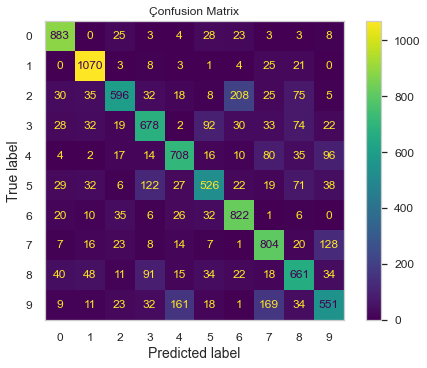

In [25]:
abc_pipeline = Pipeline([('abc_classifier', AdaBoostClassifier())])

train_classifiers(abc_pipeline, X_train, y_train, cv, 'AdaBoostClassifier')
eval_(abc_pipeline, X_test, y_test)

## GradientBoostingClassifier (Takes hours)

In [27]:
gbc_pipeline = Pipeline([('gbc_classifier', GradientBoostingClassifier())])

train_classifiers(gbc_pipeline, X_train, y_train, cv, 'GradientBoostingClassifier')
eval_(gbc_pipeline, X_test, y_test)

## XGBoost (Takes time)

In [ ]:
xbc_pipeline = Pipeline([('xbc_classifier', XGBClassifier())])

train_classifiers(xbc_pipeline, X_train, y_train, cv, 'XGBClassifier')
eval_(xbc_pipeline, X_test, y_test)

# AdaBoost, Gradient Boosting, XGBoost Regresssor : California Housing

## AdaBoostRegressor

In [31]:
train_regressor(AdaBoostRegressor(), 
                com_train_features, 
                com_train_labels, 
                cv, 
                'AdaBoostRegressor')

On an average, AdaBoostRegressor makes an error of 73.263k +/- 6.031k on the training set
On an average, AdaBoostRegressor makes an error of 73.623k +/- 6.057k on the test set


In [32]:
train_regressor(GradientBoostingRegressor(), 
                com_train_features, 
                com_train_labels, 
                cv, 
                'GradientBoostingRegressor')

On an average, GradientBoostingRegressor makes an error of 35.394k +/- 0.273k on the training set
On an average, GradientBoostingRegressor makes an error of 36.773k +/- 0.723k on the test set


In [33]:
train_regressor(XGBRegressor(objective='reg:squarederror'), 
                com_train_features, 
                com_train_labels, 
                cv, 
                'XGBRegressor')

On an average, XGBRegressor makes an error of 18.308k +/- 0.182k on the training set
On an average, XGBRegressor makes an error of 31.845k +/- 0.753k on the test set


# Exercise: Fine tune : Decision tree, Random forest, Bagging, AdaBoost, Gradient Boosting, XGBoost on MNIST and California Housing

# Assignment

## Q1,Q2,Q3 and Q4

Used Cars Price Prediction dataset: https://drive.google.com/uc?export=download&id=1tKqddJuIiRqrm7ml2qyVGJlAW3JQjaZX
</br>The target variable is 'MSRP'.

Remove the rows that contain NULL values.
</br>Drop 'Invoice' feature.
</br>Preprocess to remove comma and dollar sign from MSRP (and cast its type as integer).
</br>Use Pandas.get_dummies() on the categorical features : 'Make','Model','Type','Origin', 'DriveTrain'
</br>Split the data into X and y and then train and test subsets using 70:30 ratio with 
</br>random_state = 1

Train the model using the following (All with default values and random_state = 1):
</br>BaggingRegressor
</br>RandomForestRegressor
</br>GradientBoostingRegressor
</br>AdaBoostRegressor

In [14]:
df = pd.read_csv("wk_10_cars_data.csv")
df = df[['Make', 'Model', 'Type', 'Origin', 'DriveTrain', 'Invoice', 'EngineSize', 'Cylinders', 'Horsepower', 
         'MPG_City', 'MPG_Highway', 'Weight', 'Wheelbase', 'Length', 'MSRP']]
df.head()

,Make,Model,Type,Origin,DriveTrain,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length,MSRP
0,Acura,MDX,SUV,Asia,All,"$33,337",3.5,6.0,265,17,23,4451,106,189,"$36,945"
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,"$21,761",2.0,4.0,200,24,31,2778,101,172,"$23,820"
2,Acura,TSX 4dr,Sedan,Asia,Front,"$24,647",2.4,4.0,200,22,29,3230,105,183,"$26,990"
3,Acura,TL 4dr,Sedan,Asia,Front,"$30,299",3.2,6.0,270,20,28,3575,108,186,"$33,195"
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,"$39,014",3.5,6.0,225,18,24,3880,115,197,"$43,755"


In [16]:
df.shape

(428, 15)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Make         428 non-null    object 
 1   Model        428 non-null    object 
 2   Type         428 non-null    object 
 3   Origin       428 non-null    object 
 4   DriveTrain   428 non-null    object 
 5   Invoice      428 non-null    object 
 6   EngineSize   428 non-null    float64
 7   Cylinders    426 non-null    float64
 8   Horsepower   428 non-null    int64  
 9   MPG_City     428 non-null    int64  
 10  MPG_Highway  428 non-null    int64  
 11  Weight       428 non-null    int64  
 12  Wheelbase    428 non-null    int64  
 13  Length       428 non-null    int64  
 14  MSRP         428 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 50.3+ KB


In [18]:
df.isna().sum().to_frame().T

,Make,Model,Type,Origin,DriveTrain,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length,MSRP
0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0


In [19]:
df.dropna(inplace=True)
df.shape

(426, 15)

In [20]:
df.isna().sum().to_frame().T

,Make,Model,Type,Origin,DriveTrain,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length,MSRP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df = df[['Make', 'Model', 'Type', 'Origin', 'DriveTrain', 'EngineSize', 'Cylinders', 'Horsepower', 
         'MPG_City', 'MPG_Highway', 'Weight', 'Wheelbase', 'Length', 'MSRP']]

In [24]:
df.MSRP.str[0].value_counts()

$    426
Name: MSRP, dtype: int64

In [26]:
def temp(x):
    x = x[1:]
    x = "".join(x.split(","))
    return x

df.MSRP = df.MSRP.apply(lambda x: temp(x))

In [27]:
df.MSRP = df.MSRP.astype(int)

In [31]:
df = pd.get_dummies(df, columns=['Make','Model','Type','Origin', 'DriveTrain'])
print(df.shape)
df.info()

(426, 482)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 0 to 427
Columns: 482 entries, EngineSize to DriveTrain_Rear
dtypes: float64(2), int32(1), int64(6), uint8(473)
memory usage: 228.4 KB


In [33]:
X = df.drop(columns=["MSRP"])
y = df["MSRP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((298, 481), (128, 481), (298,), (128,))

### Enter the value of the 'score' on testing set using BaggingRegressor.

In [36]:
bag_reg = BaggingRegressor(random_state=1)
bag_reg.fit(X_train, y_train)
r2_score(y_test, bag_reg.predict(X_test))

0.7949163237522345

### Enter the value of the 'score' on testing set using RandomForestRegressor.

In [37]:
rf_reg = RandomForestRegressor(random_state=1)
rf_reg.fit(X_train, y_train)
r2_score(y_test, rf_reg.predict(X_test))

0.8369440882741959

### Enter the value of the 'score' on testing set using GradientBoostingRegressor.

In [38]:
gb_reg = GradientBoostingRegressor(random_state=1)
gb_reg.fit(X_train, y_train)
r2_score(y_test, gb_reg.predict(X_test))

0.8270485242007507

### Enter the value of the 'score' on testing set using AdaBoostRegressor.

In [39]:
ab_reg = AdaBoostRegressor(random_state=1)
ab_reg.fit(X_train, y_train)
r2_score(y_test, ab_reg.predict(X_test))

0.711903287964231

## Q5,Q6 and Q7

On the same data set, perform the preprocessing stated in the previous questions, and 
</br>perform Hyperparameter Tuning using GridSearchCV on AdaBoostRegressor. 
</br>Use random_state to be 1.
</br>Hyperparameter tuning to be done over:
</br>Use n_estimators as [100,500,1000]
</br>Use learning_rate as [0.5,1,2]
</br>Train the 'model' and compute the 'score' on the test data.

In [50]:
ada_reg = AdaBoostRegressor(random_state=1)

param_grid = {"n_estimators": [100, 500, 1000],
         "learning_rate": [0.5, 1, 2]}

gscv = GridSearchCV(ada_reg, param_grid=param_grid, refit=True, cv=4, n_jobs=-1)

gscv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=AdaBoostRegressor(random_state=1), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 1, 2],
                         'n_estimators': [100, 500, 1000]})

In [51]:
gscv.best_params_

{'learning_rate': 1, 'n_estimators': 1000}

In [52]:
gscv.best_estimator_

AdaBoostRegressor(learning_rate=1, n_estimators=1000, random_state=1)

### Enter the value of the 'score' on testing set.
Take cv value= 4

In [54]:
r2_score(y_test, gscv.best_estimator_.predict(X_test))

0.7130800769863186

### Enter the value of best n_estimators of the model after training with GridSearchCV
Take cv value= 4

In [57]:
gscv.best_estimator_.n_estimators

1000

### Enter the value of best learning_rate of the model after training with GridSearchCV
Take cv value= 4

In [58]:
gscv.best_estimator_.learning_rate

1

## Answers

1: 0.795
2: 0.837
3: 0.827
4: 0.712
5: 0.713
6: 1000
7: 1

# END